<a href="https://colab.research.google.com/github/sd3ntato/ISPR_Project/blob/main/btc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project consists in using DeepESN and (possibly)GruESN to predict bitcoin stock market price.

I use a dataset from kaggle that reports price minute by minute.

In [2]:
# reference to dataset:
# https://www.kaggle.com/mczielinski/bitcoin-historical-data

# mainstream libraries
import numpy as np
import pandas as pd
import math
import plotly.graph_objects as go

# i need code and data from my drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# import code for ESN, DeepESN, GruESN from drive
import sys
sys.path.append('/content/drive/Othercomputers/Il mio MacBook Air/SimpleESN')
sys.path.append('/content/drive/Othercomputers/Il mio MacBook Air/ISPR_Project')
from Simple_ESN import ESN
from functions import *

Mounted at /content/drive


##lettura and visualization

In [3]:
# read the dataset with data minute by minute.
data = pd.read_csv("/content/drive/MyDrive/ISPR/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
data = data.dropna(how='any') # na slots are when price does not change.
data.index = pd.RangeIndex(len(data.index))

print(f'total number of samples given: {len(data)}')
data

total number of samples given: 3613769


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
...,...,...,...,...,...,...,...,...
3613764,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
3613765,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
3613766,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
3613767,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [4]:
# visualize and work on some of the data: we take for example the last 10 000 samples (approximately one week)
data = data[-10000:]
fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])

fig.show()

##Preprocessing
shift the data separating input from target output, than separate training, validation and test data.

In [5]:
# temporal shift: we try and predict the price r minutes ahead.
r = 5

# put data inside a matrix
dataset_x = data[['Open','High','Low','Close']].to_numpy().T

# normalize data to 0 mean and 1 variance
dataset_x = normalize(dataset_x)

# separate input data from output data: output data is shifted to the left by r positions,
# so that it goes ahead by r temporal steps. 
dataset_y = np.roll(dataset_x,-r,axis=1)

# discard rolled positions because they are not meaningfull anymore
dataset_x = dataset_x[:,r:np.size(dataset_x,axis=1)-r]
dataset_y = dataset_y[:,r:np.size(dataset_y,axis=1)-r];
assert all([all(dataset_x[:,i+r]-dataset_y[:,i] == np.array([0., 0., 0., 0.]))for i in range(np.size(dataset_x,axis=1)-r ) ] )

# reshape data so that each data point is a column vector, we have a tensor containing datapoints in the form of column vector
dataset_x = dataset_x.T.reshape(-1,4,1)
dataset_y = dataset_y.T.reshape(-1,4,1)
print(f'shape of the whole dataset:{ np.shape(dataset_x)} ')

# separate training data from validation and test.
train_x = dataset_x[:3000]
train_y = dataset_y[:3000]

valid_x = dataset_x[3000:4000]
valid_y = dataset_y[3000:4000]

test_x = dataset_x[4000:]
test_y = dataset_y[4000:]

print(f'\nDATA SHAPES \ntraining data: {np.shape(train_x)},{np.shape(train_y)},\nvalidation data: {np.shape(valid_x)}, {np.shape(valid_y)}, \ntest data: {np.shape(test_x)}, {np.shape(test_y)}')

shape of the whole dataset:(9990, 4, 1) 

DATA SHAPES 
training data: (3000, 4, 1),(3000, 4, 1),
validation data: (1000, 4, 1), (1000, 4, 1), 
test data: (5990, 4, 1), (5990, 4, 1)


## ESN shallow

In [ ]:
# now that we got the data ready, we can go ahead and train a network on it, then asses the results. 
# We start with an initial very simple trial using a shallow ESN, just to see if the framework is working.
n = ESN(Nu=4, Ny=4,rho =0.9, Nr=100, r_density =0.1, i_density =1)
n.train(train_x[101:],train_y[101:],train_x[:100])
err , out = n.score(test_x,test_y)
print(f'MSE on test dataset: {err}')

MSE on test dataset: 0.036063428052221104


In [ ]:

# we arrange the obtained data in dataframes so that we can pretty-plot them
real = ohlc_matrix_to_dataframe(test_y, 1000) 
predicted = ohlc_matrix_to_dataframe(out,1000,r)

# then actually plot the results:
# we plot candlestick graph with a bar indicating the predicted Low value.

fig = plot_comparison_candlesticks_with_predicted_low(real, predicted)
fig.show()

## DeepESN readout concat

In [ ]:
from SimpleDeepESN import DeepESN
n = DeepESN(Nu=4, Ny=4,N=3,Nr=100)
n.train_concat(train_x[101:],train_y[101:],train_x[:100])
err , out = n.score_concat(test_x,test_y)
print(f'MSE on test dataset: {err}')

MSE on test dataset: 0.02341580512155221


In [ ]:

# we arrange the obtained data in dataframes so that we can pretty-plot them
real = ohlc_matrix_to_dataframe(test_y, 1000) 
predicted = ohlc_matrix_to_dataframe(out,1000,r)

# then actually plot the results:
# we plot candlestick graph with a bar indicating the predicted Low value.

fig = plot_comparison_candlesticks_with_predicted_low(real, predicted)
fig.show()

##DeepESN readout ultimo layer

In [ ]:
from SimpleDeepESN import DeepESN
n = DeepESN(Nu=4, Ny=4,N=3,Nr=100)
n.train(train_x[101:],train_y[101:],train_x[:100],2)
err , out = n.score(test_x,test_y,2)
print(f'MSE on test dataset: {err}')

MSE on test dataset: 0.0023760033948213998


In [ ]:

# we arrange the obtained data in dataframes so that we can pretty-plot them
real = ohlc_matrix_to_dataframe(test_y, 1000) 
predicted = ohlc_matrix_to_dataframe(out,1000,r)

# then actually plot the results:
# we plot candlestick graph with a bar indicating the predicted Low value.

fig = plot_comparison_candlesticks_with_predicted_low(real, predicted)
fig.show()

## GruESN

In [6]:
import tensorflow as tf
import tensorflow.keras as keras

class GruESNRZCell(keras.layers.Layer):
  def __init__(self, units, **kwargs):

    self.state_size = units
    super().__init__(**kwargs)

  def build(self, input_shape):
    
    self.Wrin = self.add_weight( shape=(input_shape[-1], self.state_size), initializer="uniform", trainable =True)

    self.Wr = self.add_weight(shape=(self.state_size, self.state_size), initializer="uniform", trainable =True)

    self.Wzin = self.add_weight(shape=(input_shape[-1], self.state_size), initializer="uniform", trainable =True)

    self.Wz = self.add_weight(shape=(self.state_size, self.state_size), initializer="uniform", trainable =True)

    self.Win = self.add_weight(shape=(input_shape[-1], self.state_size), initializer="uniform", trainable =False)

    self.W = self.add_weight(shape=(self.state_size, self.state_size), initializer="uniform", trainable =False)

    self.built = True
    
  def call(self, inputs, states):

    u = inputs
    x_tm1 = states[0]

    r = tf.math.sigmoid( tf.matmul(inputs, self.Wrin ) + tf.matmul( x_tm1, self.Wr) )
    z = tf.math.sigmoid( tf.matmul(inputs, self.Wzin ) + tf.matmul( x_tm1, self.Wz) )
    h = tf.math.tanh( tf.matmul(inputs, self.Win) + tf.matmul( tf.math.multiply(r, x_tm1), self.W ) )
    x = tf.math.multiply( z, x_tm1) + tf.math.multiply( (tf.ones(self.state_size) - z), h  )

    return x, [x]


In [7]:
import numpy as np


i = train_x.reshape(-1,1,4)
t = train_y.reshape(-1,1,4)

inp = keras.Input((None, 4))
#rnn_layer = keras.layers.RNN( GruESNRZCell(4), return_sequences=True) 
rnn_layer = keras.layers.GRU(10, return_sequences=True)
rnn_out = rnn_layer(inp)
out = keras.layers.Dense(4)(rnn_out)
model = keras.models.Model(inp,out)
model.compile(optimizer="adam", loss="mse", metrics=["mse"])

print(model.summary())
print()
print('before: ', model.test_on_batch(i,t) )

h = model.fit(i,t,epochs=50)



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
gru (GRU)                    (None, None, 10)          480       
_________________________________________________________________
dense (Dense)                (None, None, 4)           44        
Total params: 524
Trainable params: 524
Non-trainable params: 0
_________________________________________________________________
None

before:  [1.8194730281829834, 1.8194730281829834]
Epoch 1/50
94/94 [==============================] - 2s 3ms/step - loss: 1.2381 - mse: 1.2381
Epoch 2/50
94/94 [==============================] - 0s 3ms/step - loss: 0.3052 - mse: 0.3052
Epoch 3/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0564 - mse: 0.0564
Epoch 4/50
94/94 [==============================] - 0s 3ms

In [12]:
out = model.predict(test_x[:1010].reshape(-1,1,4)).reshape(-1,4,1)

# we arrange the obtained data in dataframes so that we can pretty-plot them
real = ohlc_matrix_to_dataframe(test_y, 1000) 
predicted = ohlc_matrix_to_dataframe(out,1000,r)

# then actually plot the results:
# we plot candlestick graph with a bar indicating the predicted Low value.

fig = plot_comparison_candlesticks_with_predicted_low(real, predicted)
fig.show()

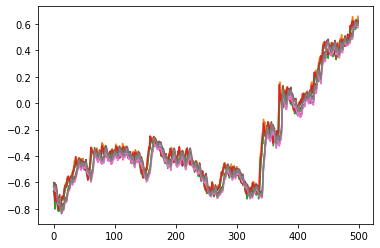

In [11]:
import matplotlib.pyplot as plt

plt.plot(t.reshape(-1,4)[:500])
plt.plot(model.predict(i).reshape(-1,4)[:500])
